### Table of contents
1. Companies selection
2. Sentiment analysis 
3. Sentiment analysis validation

## 1. Companies selection

In [25]:
import nltk
nltk.download('vader_lexicon')
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import csv
import os
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import random
import re
import scipy.stats as st

**Selecting companies to study**

From our `news_data` we can see what companies are mentioned and in how many articles. We of course would like to study those companies that are mentioned most often so we have more data to perform our sentiment analysis on. Nevertheless our `stock_data` also will condition this choice, as we want to select companies with the highest market cap possible so the finance data is most granular (e.g. every few minutes there is a stock value point) and people are most likely interested in it. Therefore we now find those companies that are most often mentioned in the `news_data` and also have the highest market cap. 


In [26]:
# READ DATA SETS

    # FINANTIAL NEWS 
news = pd.read_csv("../data/us_equities_news_dataset.csv")

    # TOP 7106 COMPANIES BY MARKET CAP
market = pd.read_csv("../data/companiesmarketcap.com - Companies ranked by Market Cap - CompaniesMarketCap.com.csv")

In [27]:
# FIND MOST FREQUENTLY MENTIONED TICKERS
tickers = news['ticker'].value_counts()
tick_mc = market[['Rank','Symbol','marketcap']]
tick_an = pd.DataFrame({'Symbol':list(tickers.index),'Article_n':list(tickers)})
tick_mc_an = tick_mc.merge(tick_an, on = 'Symbol').head(n=20).sort_values(by= 'Article_n', ascending= False).reset_index()
tick_mc_an.head(n = 20)

,index,Rank,Symbol,marketcap,Article_n
0,0,1,AAPL,2245746491392,20231
1,1,3,MSFT,1791532859392,8110
2,16,25,BAC,296829911040,7409
3,2,5,AMZN,942841135104,6330
4,3,7,TSLA,562562130000,4283
5,6,10,XOM,455235764224,2831
6,9,14,JPM,400557768704,2600
7,19,32,KO,270195392512,1367
8,8,12,WMT,415197298688,1267
9,11,17,CVX,350046846976,1105


From the data above it is clear that all of the $20$ copmanies with the highest number of articles have a high enough market cap. The company with the lowest value is `KO` (i.e. The Coca Cola Company) with a marketcap of 270,195,392,512$. It is also clear that selecting any company from aoutside this top $20$ will result problematic, as they amount of articles becomes very low (i.e. $<200$ for a period of a few years). All and all, we decide to move on with the analysis with the $20$ companies with most articles. 

In [28]:
ticker_list = list(tick_mc_an.head(n = 20)['Symbol'])

## 2. Sentiment analysis 

Once the companies to be analyzed have been chosen, we can move on to extracting the sentiment in each of the articles that mention them. 

In [29]:
# USE SELECTED COMPANIES
companies_data = news[news['ticker'].isin(ticker_list)]
companies_data = companies_data.dropna()

What follows is the code that studies the content of each article in `news_data` and adds two rows to it: a sentiment score ranging from $-1$ to $1$ and a discrete version of this score with values $-1$, $0$ or $1$. The method used to perform this sentiment analysis is a dicionary based one from the Python package `nltk`. Although an alternative method using a pre-trained neural network was tested, the present method was $100$ times faster and resulted in an at least equally good performance. 

(To see/test the neural network alternative see two cells down)

In [30]:
# RULE-BASED/DICTIONARY SENTIMENT ANALYSIS
dic_method = SentimentIntensityAnalyzer()

dic_sent_scores = []
for article in companies_data.content:
    dic_sent_scores.append(dic_method.polarity_scores(article)['compound'])

    # ALSO ADD DISCRETE SCORE
dic_sent_scores_dis = []
for s in dic_sent_scores: dic_sent_scores_dis.append(1) if s>0 else  dic_sent_scores_dis.append(-1)

companies_data['dic_sentiment'] = dic_sent_scores
companies_data['dic_sentiment_dis'] = dic_sent_scores_dis


LookupError: 
**********************************************************************
  Resource [93mvader_lexicon[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('vader_lexicon')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93msentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt[0m

  Searched in:
    - '/home/derk/nltk_data'
    - '/home/derk/Documents/GitHub/Project_SDA/venv/nltk_data'
    - '/home/derk/Documents/GitHub/Project_SDA/venv/share/nltk_data'
    - '/home/derk/Documents/GitHub/Project_SDA/venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [ ]:
# B) PRE-TRAINED SENTIMENT CLASSIFIER
# from flair.models import TextClassifier
# from flair.data import Sentence

# ml_method = TextClassifier.load('en-sentiment')

# def get_sent(text):
#     n_text = Sentence(text)
#     ml_method.predict(n_text)
#     if 'POSITIVE' in str(n_text.labels[0]):
#         return 1
#     elif 'NEGATIVE' in str(n_text.labels[0]):
#         return -1
#     else:
#         return 0

# ml_sent_scores = []
# for article in companies_data.content:
#     ml_sent_scores.append(get_sent(article))

# companies_data['ml_sentiment'] = ml_sent_scores

Finally, we save the resulting `news_data` with its new two sentiment columns to a csv

In [ ]:
# companies_data.to_csv('data\news_select_companies_with_sent.csv')

## 3. Sentiment Analaysis Validation

In order to test to what extend the chosen `nltk` sentiment analysis algorithm corresponds to reality, two tests will be performed based on a sample of $20$ manually annotated articles. This sample used for validation will be composed by $1$ randomly chosen article for each of the $20$ initially chosen companies (NOTE: these companies may not correspond to the ones used in the final analysis). Atlhough other sampling methods were considered (e.g. sample with same amount of articles per sentiment score interval), this approach was deemed most likely to give representative results of the quality of the overall sentiment measures. 

In [ ]:
# CODE TO GENERATE A SAMPLE OF 20 ARTICLES (ONE PER COMPANY) 

sample_articles = pd.DataFrame({'id':np.repeat(0,20),'article':np.repeat(0,20),'score':np.repeat(0,20)})

for i, ticker in enumerate(list(set(companies_data.ticker))):       
    c = random.randint(0,companies_data[companies_data['ticker'] == ticker].shape[0])
    picked_entry = companies_data[companies_data['ticker'] == ticker].iloc[c,:]
    sample_articles.iloc[i,0] = picked_entry['id']
    sample_articles.iloc[i,1] = picked_entry['content']
    sample_articles.iloc[i,2] = picked_entry['dic_sentiment']

# CODE TO SAVE GENERATED SAMPLE
# sample_articles[['id','article']].to_csv('Sample_articles.csv')


In [ ]:
# CODE TO READ IN A GIVEN SAMPLE OF ARTICLES 
manual_label = pd.read_csv(r'data\Sample_articles.csv')

The first test evaluates to what extend the human sentiment score is significantly different from the measured score. Analyzing the sentiment of a text is a noise process. Although for text $X$ we observed a certain score, if the text had been written in a slightly different way, even still having the same actual score, we may have measured a slightly different one. We uses a bootstrap procedure to simulate this distribution of possible scores and test if the human sentiment score could have stemed from it with $\alpha = 0.05$. 

In [ ]:
# FUNCTIONS FOR NEW VERSIONS OF TEXT AND FOR SENTIMENT ANALYSIS 

    # CREATE FREQUENCIES DICTIONARY 
def word_frequencies(text):
    freqs = {}
    list_words = re.sub(' +', ' ', text).split()
    for w in list_words:
        if w in freqs: 
            freqs[w] += 1
        else: 
            freqs[w] = 1
    return freqs

    # CREATE NEW RE-SAMPLED TEXT
def new_text(text):
    freqs = word_frequencies(text)
    length = sum(freqs.values())
    new_words = []

    while len(new_words) < length:
        new_words.append(random.choices(list(freqs.keys()),weights=list(freqs.values()))[0])

    new_text = ' '.join(new_words)
    return new_text

    # SENTIMENT ANALYSIS
def measure_sentiment(text):
    dic_method = SentimentIntensityAnalyzer()
    return dic_method.polarity_scores(text)['compound']



In [ ]:
# CREATE THE DISTRIBUTION OF POSSIBLE SENTIMENT SCORES FOR EACH ARTICLE
n = 1000
articles_boot_dists = []

for id in manual_label['id']:
    an_article = str(companies_data[companies_data['id'] == id].content.values[0])

    scores = []
    for i in range(n): 
        new_article = new_text(an_article)
        scores.append(measure_sentiment(new_article))

    articles_boot_dists.append(scores)

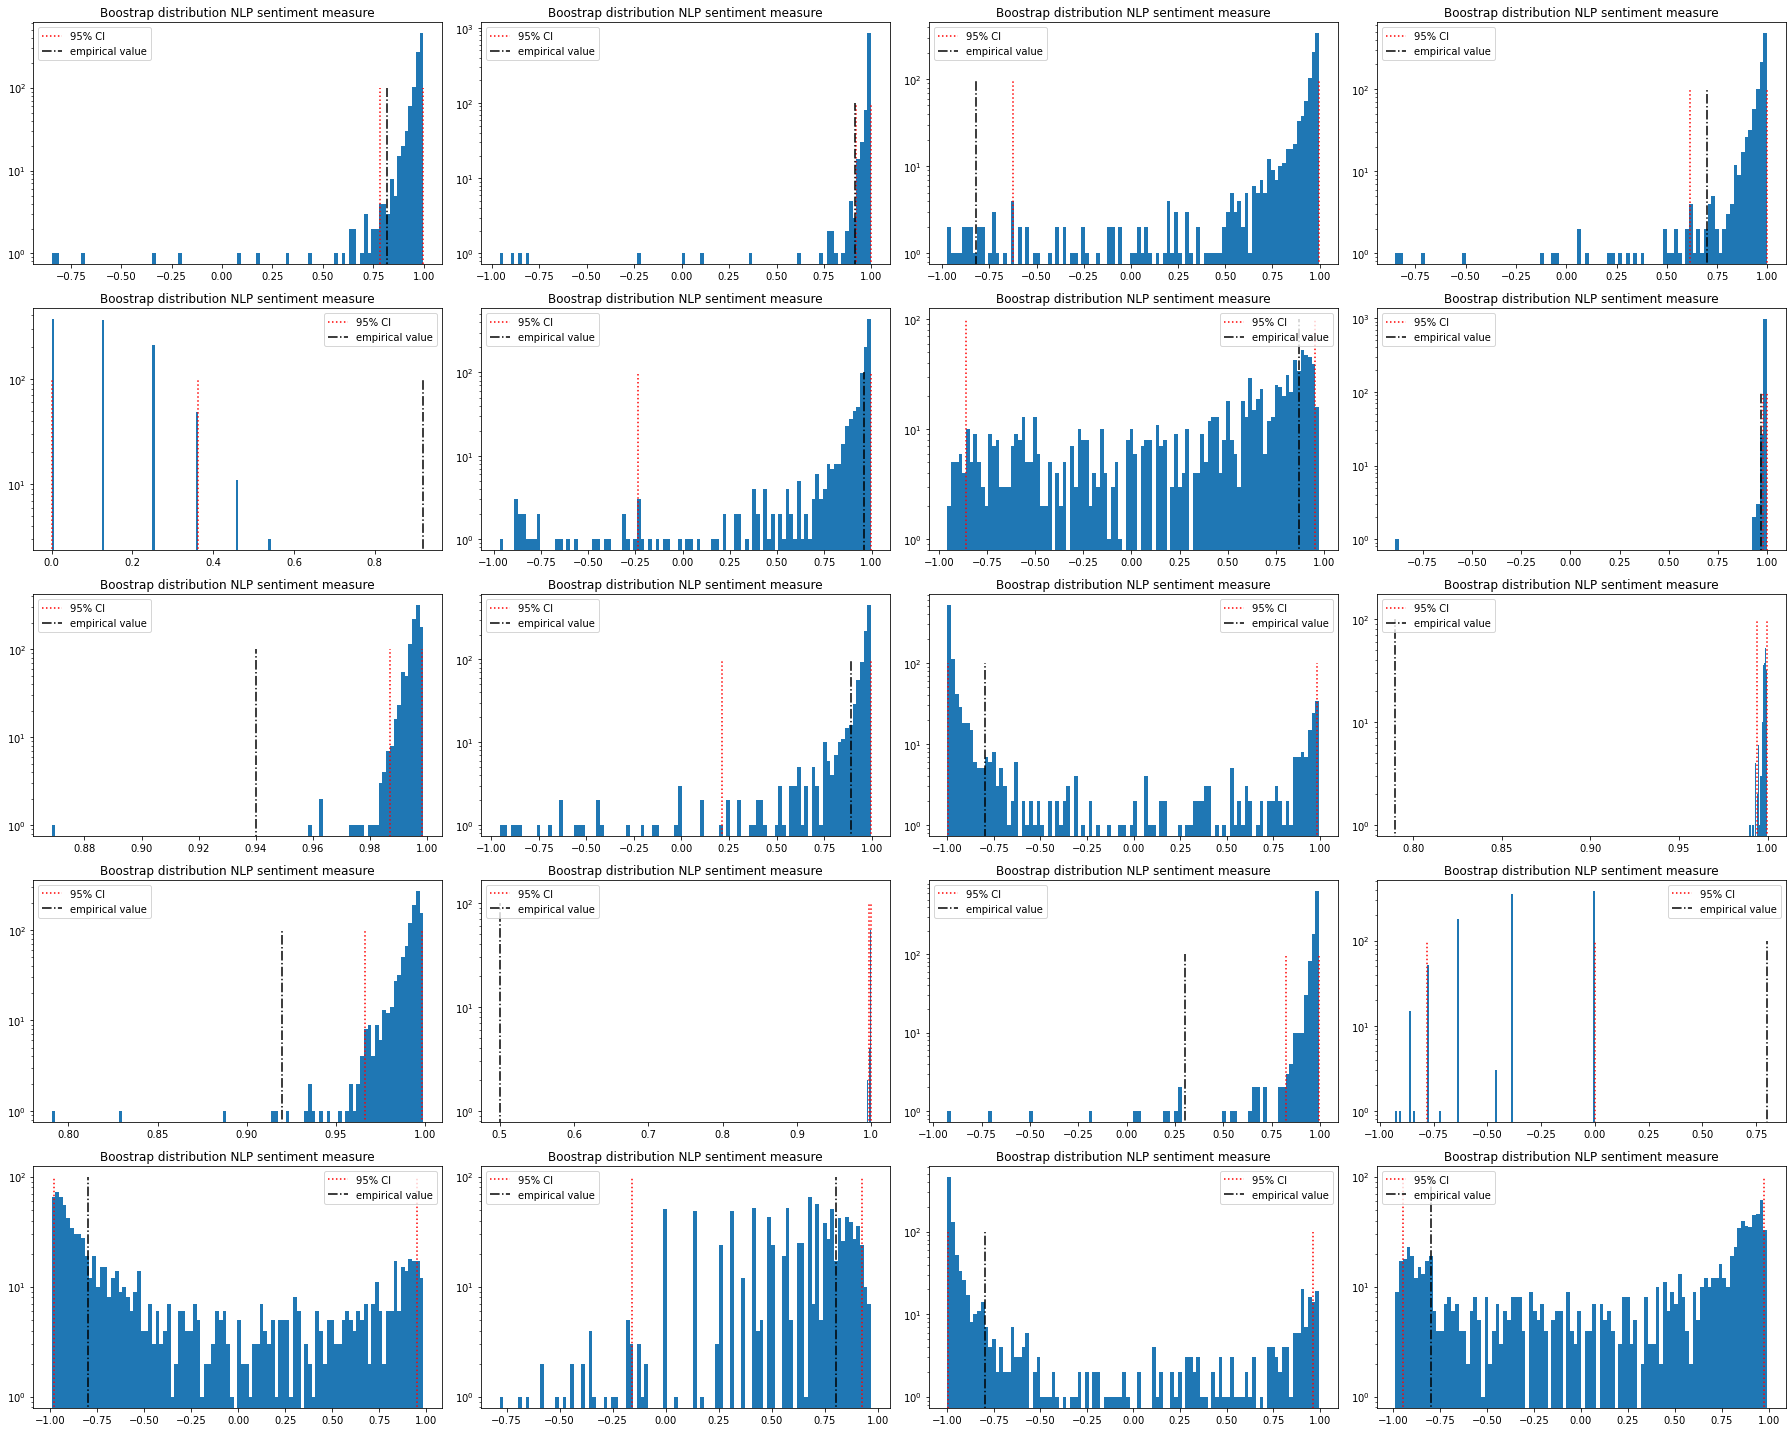

In [ ]:
# PLOT ALL DISTRIBUTIONS
plt.figure(figsize=(25,20))

for i, dist in enumerate(articles_boot_dists): 
    plt.subplot(5,4,i+1)
    plt.hist(dist,bins = 100)
    plt.vlines(np.percentile(dist,97.5),0,100,linestyles='dotted',color = 'red')
    plt.title('Boostrap distribution NLP sentiment measure')
    plt.vlines(np.percentile(dist,2.5),0,100,linestyles='dotted',color = 'red',label = '95% CI')
    plt.vlines(manual_label['h_score'][i],0,100,linestyles='dashdot',color = 'black',label = 'empirical value')
    plt.yscale('log')
    plt.legend()
    # plt.title(f"id = {manual_label['id'][i]}")

plt.tight_layout()
plt.savefig('matrix_present.jpg')

**Note on the previous 20 articles**

We can identify three typical behaviors in the texts bootstrap distributions. First, we have a majority of unimodal 'dense' distributions (e.g. `id = 267447`). This are not concerning and seem valid distributions on which a regualar $CI$ can be computed. Seconldy, we have some unimodal distribution with very sparse values (e.g. `id = 421353`). The reason for this appearance is that this texts are much shorte and therefore there are many less possible new texts arising from the bootstrap, resulting in just a few possible values for the sentiment to take. Although strange looking, this distributions are also not considered problematic when computing a regular $CI$. Finally, we also observe some bi-modal distributions (e.g. `id = 428297`). This distributions are problematic as a regular $CI$ is designed for unimodal distributions. In order to perform a signficance test on this bimodal distributions an appropriate $CI$ is designed.

In [ ]:
# CODE FOR A BIMODAL CONFIDENCE INTERVAL
def hist_bi_ci(scores):
        
    a_hist = plt.hist(scores,bins = 100)

    # SMOOTH HEIGHTS
    smth_heights = []
    for i in range(len(a_hist[0])):
        if i == 0:
            smth_heights.append(np.mean([a_hist[0][i],a_hist[0][i+1]]))
        elif i == (len(a_hist[0])-1):
            smth_heights.append(np.mean([a_hist[0][i-1],a_hist[0][i]]))
        else: 
            smth_heights.append(np.mean([a_hist[0][i-1],a_hist[0][i],a_hist[0][i+1]]))

    # CREATE LIST TUPLES WITH HEIGHT AND BOUNDARY
    heigh_bound = [(smth_heights[i],a_hist[1][i]) for i in range(len(a_hist[0]))]
    heigh_bound.sort(key = lambda x:x[0],reverse= True)

    # CHOOSE BINS UNTIL 95% IS REACHED
    ci_bins = []
    i = 0

    while (sum([x[0] for x in ci_bins])/sum(smth_heights))<0.95:
        ci_bins.append(heigh_bound[i])
        i += 1

    # TRY AND PLOT THIS 
    L_L = min([x[1] for x in ci_bins if x[1]<0])
    L_R = max([x[1] for x in ci_bins if x[1]<0])
    R_L = min([x[1] for x in ci_bins if x[1]>0])
    R_R = max([x[1] for x in ci_bins if x[1]>0])

    plt.yscale('log')
    plt.vlines(L_L,0,100,linestyles='dotted',color = 'red',label = '95% CI')
    plt.vlines(L_R,0,100,linestyles='dotted',color = 'red')
    plt.vlines(R_L,0,100,linestyles='dotted',color = 'red')
    plt.vlines(R_R,0,100,linestyles='dotted',color = 'red')



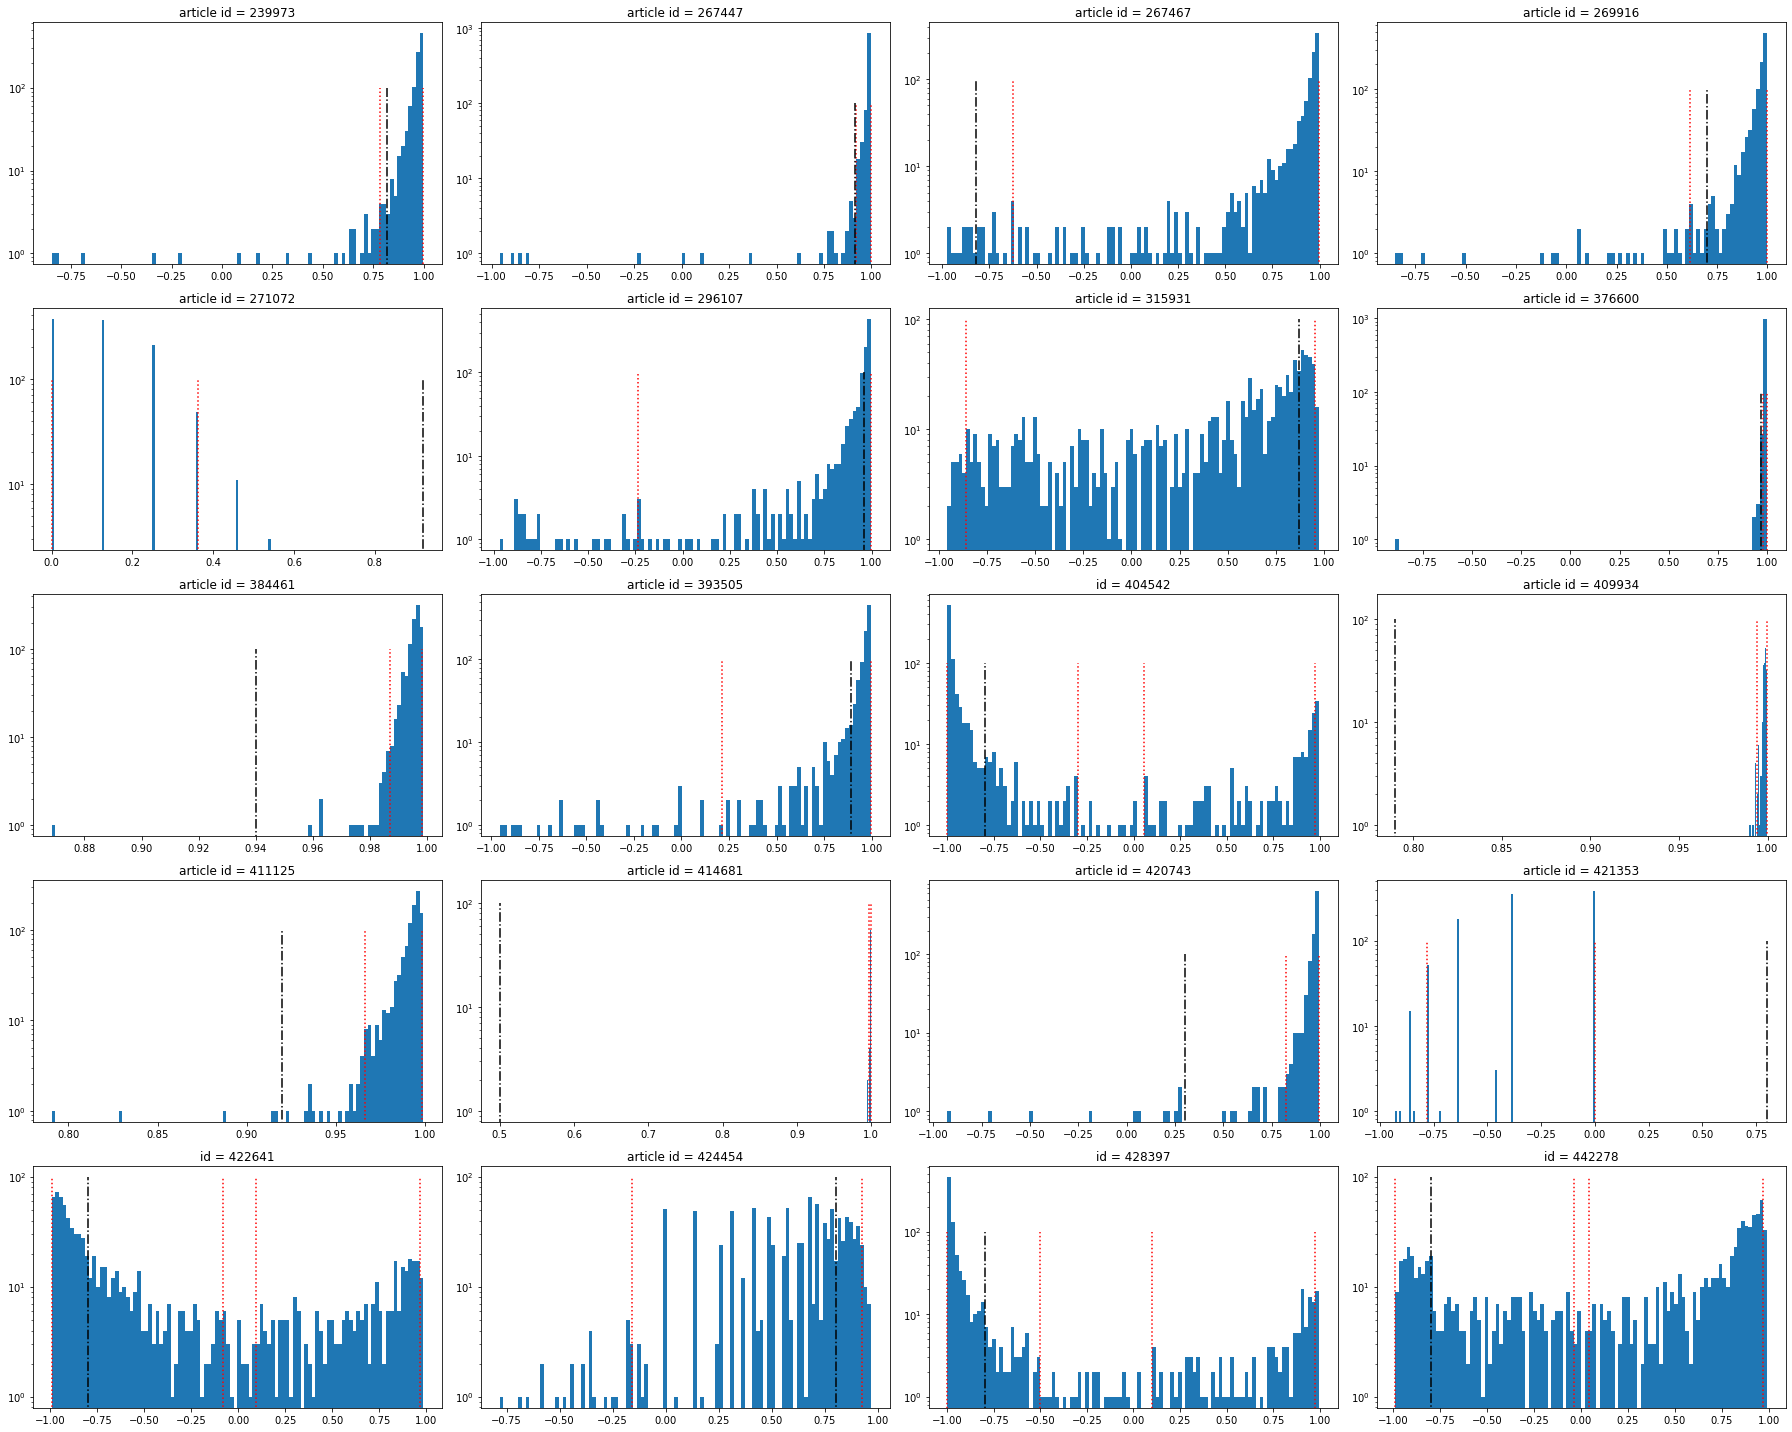

In [ ]:
# PLOT ALL DISTRIBUTIONS WITH CORRECT BIMODAL CI

plt.figure(figsize=(25,20))

for i, dist in enumerate(articles_boot_dists): 
    if i in [10,16,18,19]:
        plt.subplot(5,4,i+1)
        hist_bi_ci(dist)
        plt.title(f"id = {manual_label['id'][i]}")
        plt.vlines(manual_label['h_score'][i],0,100,linestyles='dashdot',color = 'black')
    else:
        plt.subplot(5,4,i+1)
        plt.hist(dist,bins = 100)
        plt.vlines(np.percentile(dist,97.5),0,100,linestyles='dotted',color = 'red')
        plt.vlines(np.percentile(dist,2.5),0,100,linestyles='dotted',color = 'red')
        plt.vlines(manual_label['h_score'][i],0,100,linestyles='dashdot',color = 'black')
        plt.yscale('log')
        plt.title(f"article id = {manual_label['id'][i]}")

plt.tight_layout()
plt.savefig('matrix_present.jpg')

From the reults above we can see that $9$ out of the $20$ sentiment scores are significantly different. Using an $\alpha$ level of $0.05$ we would expect $1$ sentiment score to be significantly different under $H_0:$ both scores come from the same distribution. Thus, we must reject this hypothesis and acknowledge that the measured scores do not stem from the same distribution as the human ones. 

Although the previous test shows that the human and the measured scores are systematically different, they may still be related and thus the measured score would tell us something about the human ('actual') sentiment score. The following test checks if this is te case by computing the *Pearson correlation* between the human score and the measured score for the $20$ sample articles and, through bootstraping, testing if it signifacntly different than $0$. This bootstrap procedures involves generating the $H_0$ distribution (i.e. the distribution of $r$ values that we would expect if there was no correlation between the two scores) by shuffling one of the two score vectors, and performing a *Pearson correlation* with the other unshufled score vector. Performing this, for instance, $10^4$ times would generate a good estimate of the $H_0$ distribution and we can test whether our actual $r$ value belongs to this distribution with an $\alpha = 0.05$. 

In [ ]:
# VECTOR WITH MESURED SCORES FOR THE SAMPLE
both_scores = companies_data[companies_data['id'].isin(manual_label.id)]
both_scores = both_scores.merge(manual_label,on = 'id')[['dic_sentiment','h_score']]

# USING A TEMPORARY RANDOM HUMAN SCORE
# h_scores = [(0.1+1.2*x)+np.random.normal(0,0.2,1)[0] for x in m_scores]
m_scores = list(both_scores['dic_sentiment'])
h_scores = list(both_scores['h_score'])

# ACUTAL CORRELATION COEFFICIENT
actual_cor = np.corrcoef(h_scores,m_scores)[0][1]

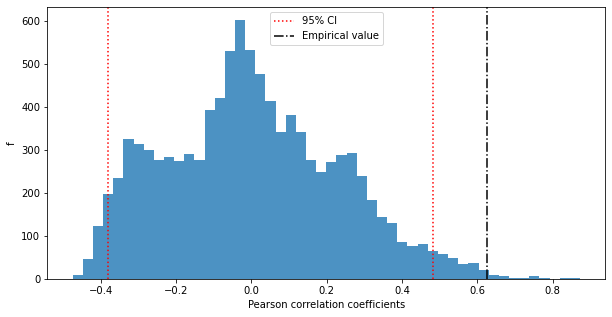

In [ ]:
# CREATING A NULL DISTRIBUTION OF CORRELATION VALUES THROUGH BOOTSTRAP
n = 10**4
cor_coefs = []
for i in range(n):
    new_h_scores = random.sample(h_scores,len(h_scores))
    cor_coefs.append(np.corrcoef(m_scores,new_h_scores)[0][1])

sum([1 if cor>actual_cor else 0 for cor in cor_coefs])/len(cor_coefs)

plt.figure(figsize = [10,5])
plt.hist(cor_coefs,bins = 50,alpha = 0.8)
plt.axvline(x = np.percentile(cor_coefs,97.5),color = 'red', linestyle = 'dotted',label = '95% CI')
plt.axvline(x = np.percentile(cor_coefs,2.5),color = 'red', linestyle = 'dotted')
plt.axvline(x = actual_cor,color = 'black', linestyle = 'dashdot',label = 'Empirical value')
plt.xlabel('Pearson correlation coefficients')
plt.ylabel('f')
plt.legend()
plt.show()


As we can see in the previous plot, the observed correlation coefficient falls oustide of the critical value of te null distribution. Thus, we can reject the hypothesis that the correlation stems from randomness. There is a relationship between the measured sentiment and the 'actual' sentiment of the articles, and this implies that the measured sentiment is a meaningful indicator worth using in further analysis. 